# Programming for Data Science
## NOVA IMS
## Final project
Group 22

#### Student Names:

Ernesto Javier Aguilar Madrid (M20190559) <br/> 
Maria Leonor Furtado (M20190308) <br/> 
Bojan Stavrikj (M20190562) <br/> 



# STEP 1: Importing/Installing necessary libraries 

Uncomment the following code to install the plotly package according to the environment you are using:
- First line is for Anaconda
- Second line is for Python

In [1]:
#conda install -c plotly plotly
#%pip install plotly

In [2]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
import os
import seaborn as sns
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq, kmeans2
from scipy.spatial.distance import euclidean,cdist
import statsmodels.api as sm 
from sklearn.cluster import SpectralClustering 
from sklearn.metrics import silhouette_score
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# STEP 2: Define all functions to be used in the main code

"clean_data" function (takes 4 arguments a Dataframe, a list,a integer and a boolean)- this function does the following: <br/> 
- Drops any column that has too much missing data (with more than 50 empty rows)
- Drop columns that are descriptive and not needed
- Drop rows with more than 12 empty columns(years) (the logic for this is that we want at least 10 years of data)
- Fill empty values for numeric cols row by row i.e. by country using linear interpolation from the oldest years to the new
- Drop columns (years) before 2000 depending on the recency that we are looking for the specific analysis (set drop_years)
- Reset the index of the dataframe after cleaning the data


In [3]:
#define function that cleans the dataset

def clean_data(df,columns_to_drop,numeric_loc,drop_years):
    
    """
    This function returns a clean dataframe. 
    df: list of the static columns name.
    columns_to_drop: list of the static column names you want to drop.
    numeric_loc: an integer representic the location of the first numeric column in your Dataframe.
    drop_years: a boolean, set True if you would like to drop columns before the year 2000.
    """
    
    #drop columns with more than 50 empty rows
    
    df=df.dropna(axis=1,thresh=50)

    #drop the indicator name,code variables as they are not needed

    df=df.drop(columns_to_drop, axis=1)

    #drop rows with more than 12 missing years
    df=df.dropna(axis=0,thresh=12)

    # fill empty values for numeric cols with linear interpolation country by country
    df.iloc[:,numeric_loc:]= df.iloc[:,numeric_loc:].interpolate(method='linear', limit_direction='forward', axis=1)
    
    #drop values before 2000 if drop_values = True
    if drop_years:
        try:
            df=pd.concat([df.iloc[:,:numeric_loc],df.loc[:,'2000':]],axis=1)

        except Exception:
            pass
    else:
        pass
    df.reset_index(drop=True,inplace=True)
    return df

"separate_df" function ( this function takes 2 Dataframes as arguments) - this function does the following: <br/> 
- Left join of the main data Dataframe with the country metadata Dataframe (contaning Income Group and Region data)
- Using the logic that the Region column is only populated for rows that represent Countries and it is empty for rows that represent aggregates of countries (e.g., world regions), we separate the Dataframe into 2 Dataframes ( Region and Country)
- Following this we drop the Region and IncomeGroup column from the region_df as these are empty

In [4]:
#function to left join df with the income/region metadata and separate them into 2 different dfs country and region

def separate_df(data_df, metadata_df):
    """
    This function returns 2 dataframes, one for the countries and one for the regions. 
    data_df: The original data DataFrame.
    metadata_df: The metadata Dataframe containing the Income Group and Region information for each country.
    """
    # left join the 2 dataframes
    combined_df= pd.merge(data_df,metadata_df, on='Country Code', how='left')
    
    # seperate countries and regions in 2 different dataframes
    
    country_df = combined_df[combined_df["Region"].notna()]
    region_df = combined_df[combined_df["Region"].isna()]
    
    region_df.drop(["Region", "IncomeGroup"], axis=1, inplace=True)
    
    return country_df, region_df

"create_dummies" function ( this function takes 2 arguments a Dataframe and a string) - this function does the following: <br/> 
- Convert categorical column into several int columns using one hot encoding
- Join the one hot encoding columns into the original DataFrame
- Drop the original categorical column from the original DataFrame

In [5]:
#define function to create dummies for given column and remove it from df

def create_dummies(df,col_name):
    """
    This function returns a Dataframe with dummy variable columns. 
    df: The original data DataFrame.
    col_name: a string with the column name corresponding to the categorical column you would like to one hot encode.
    """
    
    #turn column into dummies
    
    enc = pd.get_dummies( df[col_name])
    
    #join dummies at the end of df
    
    df = pd.concat([df, enc], axis=1)
    
    #drop original column from df
    
    df.drop(col_name,axis=1,inplace=True)
    
    return df

"separate inv" function ( this function takes 1 Dataframe and 3 strings as arguments) - this function does the following: <br/> 
- Left join of the main data Dataframe with the country metadata Dataframe (contaning Income Group and Region data)
- Using the logic that the Region column is only populated for rows that represent Countries and it is empty for rows that represent aggregates of countries (e.g., world regions), we separate the Dataframe into 2 Dataframes ( Region and Country)
- Following this we drop the Region and IncomeGroup column from the region_df as these are empty

In [6]:
#define a function to breakdown the GDP investment df into subcategories

def separate_inv(inv_df, ind, ind_value, sub_ind, sub_ind_value):
    """
    This function returns a Dataframe with a subset of data from the original Dataframe. 
    ind: The string corresponding to the column to be filtered
    ind_value: a string with the value you would like to filter the col specified in the previous argument on.
    sub_ind: The string corresponding to the second column to be filtered.
    sub_ind_value: a string with the value you would like to filter the col specified in the previous argument on.
    """

#select indicator to be split
    split_1 = inv_df[inv_df[ind] == ind_value]

#select sub-indicator to be split
    split_2 = split_1[split_1[sub_ind] == sub_ind_value]

#drop indicator/subindicator columns
    split_2.drop(ind,axis=1,inplace=True)
    split_2.drop(sub_ind,axis=1,inplace=True)

    return split_2

"unpivot" function ( this function takes 1 Dataframe, 1 list, 2 strings as arguments) - this function does the following: <br/> 
- checks the arguments provided are of the required object type
- unpivots the Dataframe provided based on the list of the static columns name, the new name for the new column of unpivoted columns and new name for the new column of unpivoted values

In [7]:
def unpivot(df, L, cl_var_name, cl_value_name):
    """
    This function returns unpivoted dataframe. 
    df: original data DataFrame
    L: list of the static columns name.
    cl_var_name: new name for the new column of unpivoted columns (first row). 
    cl_value_name: new name for the new column of unpivoted values (second to last rows).
    """
    
    # Check if first introduced object is a dataframe
    if not isinstance(df, pd.DataFrame):
        print("The first introduced argument should be a dataframe.")
        return None

    # Check if the second introduced object is a list
    if not isinstance(L, list):
        print("The second introduced argument should be a list.")
        return None

    # Check if the third introduced object is a string value
    if not isinstance(cl_var_name, str):
        print("The third introduced argument should be a string value.")
        return None

    # Check if the fourth introduced object is a string value
    if not isinstance(cl_var_name, str):
        print("The fourth introduced argument should be a string value.")
        return None

    # Unpivot dataframe
    unpivoted_df = df.melt(id_vars=L,
                           var_name=cl_var_name,
                           value_name=cl_value_name)
    return unpivoted_df

"kmeans_fillna" function ( this function takes 1 Dataframe and 2 strings as arguments) - this function does the following: <br/> 
- It fills the empty values in the predictor columns specified with the mean
- Converts these columns to numeric columns
- splits the df into incomplete ( where variable to be predicted is empty) and complete dataframes
- fit the KNeighbours regressor on the complete df
- Predict the values for the variable to be predicted using the incomplete df
- Fill na with predicted values in the original df

In [8]:
#define a function to fill in missing values in each column using kmean regressor
def kneigh_fillna (df,X,y):
    """
    This function returns a dataframe with filled na values using KNeighbours. 
    df: original data DataFrame
    X: list of the static columns names to be used to predict na values.
    y: string corresponding to the name of the value to fill na values
    """
#select the other variables to be used in the regressor for prediction and fill in their missing values with respective averages
#(avg fillna applied because kmeans regressor doesn't work with variables that have missing values)
    tempavg = df[X].fillna(df.mean())
#filter on columns of interest and convert them to numeric
    reg = pd.concat([tempavg,df[y]],axis=1).apply(pd.to_numeric)

#splitting the reg dataframe to incomplete table 
#contains the rows of each Nan value of variable to be predicted in reg df
    incomplete = reg[reg[y].isna()]
    
#splitting the reg dataframe to complete table 
#contains the rows of each valid value of the variable to be predicted in reg df
    complete = reg[~reg.index.isin(incomplete.index)]

#setting the kNeighbours regressor using euclidean distances
    regressor = KNeighborsRegressor(10,weights = 'distance',metric = 'euclidean')

#applying the regressor to the dataframe
    fitting = regressor.fit(complete.loc[:,X],complete.loc[:,[y]])
    
#predicting the values in the incomplete table 
    incomplete["y_pred"] = fitting.predict(incomplete.drop(columns=[y]))

#applying concatenate to the original df
    df = pd.concat([df,incomplete["y_pred"]],axis=1)

#fillna of dependent and predicted columns with 0, to be able to add back to the original df
    df[[y,"y_pred"]] = df[[y,"y_pred"]].fillna(0)

#add the new values to the original column in the original df
    df[y] = df[y] + df["y_pred"] 

#drop the predicted column from the original df
    df.drop(columns=["y_pred"],inplace=True)

#return the original df
    return df

"elbow_plot" function ( this function takes 1 Dataframe, 1 integer as arguments) - this function does the following: <br/> 
- It takes a range of ks
- Runs KMeans for each of the values of k, stores the total inertia and value of k
- plots these in a graph and prints the sse values
- fit the KNeighbours regressor on the complete df
- Predict the values for the variable to be predicted using the incomplete df
- Fill na with predicted values in the original df

In [9]:
# finding the optimal number of clusters

def elbow_plot(data,max_k):
    """
    This function returns a plot and prints a dataframe of plot values. 
    data: original data DataFrame
    max_k: integer representing the max of the range of values of k from [1,k]
    """

    # elbow
    cluster_range = range(1,max_k)
    sse = {}
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, 
                    random_state=0,
                    n_init = 10,
                    max_iter = 300).fit(data)
        data["Clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure(figsize=(8,5))
    plt.plot(list(sse.keys()), list(sse.values()),
             linewidth=1.5,
             linestyle="-",
             marker = "X",
             markeredgecolor="salmon",
             color = "black")
    plt.title ("K-Means elbow graph", loc = "left",fontweight = "bold")
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.axvline(x = 3, alpha = 0.4, color = "salmon", linestyle = "--")
    plt.show()
    clusters_df = pd.DataFrame.from_dict(sse,orient='index',columns=['Inertia'])
    print (clusters_df)


"compare_init_methods" function (takes 1 Dataframe,1 list, 1 integer as arguments) - it does the following: <br/> 
- It takes a cluster number, value of K
- Runs KMeans for each of the values of the provided initialisation methods
- plots these in a graph for 4 iterations ( since Kmeans is very sensitive to the initial position of the seeds)

In [10]:
#finding best initialisation method
def compare_init_methods(data,list_init_methods,K_n):
    """
    This function returns a plot comparing the range of initialisation methods cluster plots with 4 runs. 
    data: original data DataFrame
    list_init_methods: list of initialisation methods for the Scipy learn kmeans2 method.
    K_n: integer representing the number of clusters i.e. value of k in the kmeans funtion
    """
    keys=[]
    centroids_list=[]
    labels_list=[]
    for i in range(1,5):
        fig, axs = plt.subplots(len(list_init_methods), 2, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
        fig.suptitle('Initialization Method Comparision nr {}'.format(i))

        for index, init_method in enumerate(list_init_methods):
            centroids, labels = kmeans2(data, k=K_n,minit=init_method)
            keys.append("{}:{}".format(i,init_method))
            centroids_list.append(centroids)
            labels_list.append(labels)
            axs[index, 0].plot(data[labels == 0, 0], data[labels == 0, 1], 'ob',
                 data[labels == 1, 0], data[labels == 1, 1], 'or',
                 data[labels == 2, 0], data[labels == 2, 1], 'oy')
            axs[index, 0].plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=5)


            axs[index, 1].plot(data[labels == 0, 2], data[labels == 0, 3], 'ob',
                 data[labels == 1, 2], data[labels == 1, 3], 'or',
                 data[labels == 2, 2], data[labels == 2, 3], 'oy')
            axs[index, 1].plot(centroids[:, 2], centroids[:, 3], 'sg', markersize=5)
            axs[index, 0].set_title("Method:{}".format(init_method), y=0.7)
    return keys, centroids_list, labels_list

"test_stationarity" function ( this function takes 1 Dataframe, 1 string as arguments) - this function does the following: <br/> 
- checks for stationarity in the data
- The first part represents the moving average and std visually
- The second part calls on a Dickey Fuller test to check for stationariry

In [11]:
def test_stationarity (timeseries, var):
    """
    This function returns a plot visualisation and prints Dickey Fuller test
    timeseries: timeseries data DataFrame
    var: string corresponding to the name of the column to be assessed
    """
    
    #determining rolling statistics with a rolling window of 2 years
    movingAverage = timeseries.rolling(window=2).mean()
    movingSTD = timeseries.rolling(window=2).std()
    
    #plotting the original mean and std data
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red',label='Rolling Mean')
    std = plt.plot(movingSTD, color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #calling a Dickey Fuller test statistic
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(trial[var],autolag='AIC')

    dfoutput= pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Numbers of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

# STEP 3: Importing data

In [12]:
# import data from csv file using pandas .read_csv, in the following order:
# expenditure, international inbound tourist, start-up procedures to register a business, 
# population, country region, GDP and investment information
raw_receipt = pd.read_csv(os.path.join(os.getcwd(), 'API_ST.INT.RCPT.CD_DS2_en_csv_v2_259854.csv'), skiprows=4)
tourist_df = pd.read_csv(os.path.join(os.getcwd(),"API_ST.INT.ARVL_DS2_en_csv_v2_103871.csv"), skiprows=4)
startup_df = pd.read_csv(os.path.join(os.getcwd(),"Start-up procedures to register a business.csv"),skiprows =4)
population = pd.read_csv(os.path.join(os.getcwd(),'Population by country.csv'), encoding="ISO-8859-1",skiprows=4)
country_info = pd.read_csv(os.path.join(os.getcwd(),"Metadata_Country_API_ST.INT.ARVL_DS2_en_csv_v2_103871.csv"), usecols=[0,1,2])
investment_GDP_df = pd.read_csv(os.path.join(os.getcwd(),"Public_Private Spending on travel and Tourism service.csv"))

# STEP 4: Cleaning & Categorizing the data

In [13]:
# Using "clean_data" function to preparate the data
receipt_df = clean_data(raw_receipt,["Indicator Name", "Indicator Code"],2,drop_years=True)
tourist_df = clean_data(tourist_df,["Indicator Name", "Indicator Code"],2,drop_years=True)
startup_df = clean_data(startup_df,["Indicator Name", "Indicator Code"],2,drop_years=True)
population = clean_data(population,["Indicator Name", "Indicator Code"],2,drop_years=True)
investment_GDP_df = clean_data(investment_GDP_df,["Indicator Id"],4,drop_years=True)

# Renaming some columns
investment_GDP_df = investment_GDP_df.rename(columns={'Country ISO3': 'Country Code'})

# Drop years 2020 and onwards
investment_GDP_df.drop(investment_GDP_df.iloc[:,-9:], axis=1,inplace=True)


In [14]:
# Using the "separate_inv" for times to breakdown the GDP investment dataframe into subcategories by 
# choosing a single Indicator
GDP_pct = separate_inv(investment_GDP_df,
                       "Indicator",
                       'Travel and Tourism total contribution to GDP',
                       'Subindicator Type',
                       'Percentage share of total GDP')

GDP_govt = separate_inv(investment_GDP_df,
                        "Indicator",
                        'Government spending on travel and Tourism service',
                        'Subindicator Type',
                        "US$ in bn (Real prices)")

GDP_govt_pct = separate_inv(investment_GDP_df,
                            "Indicator",
                            'Government spending on travel and Tourism service',
                            'Subindicator Type',
                            "% share of total tourism expenditure")

GDP_cap = separate_inv(investment_GDP_df,
                       "Indicator",
                       'Capital investment in Travel and Tourism',
                       'Subindicator Type',
                       "US$ in bn (Real prices)")

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
# Reestructuring the data using unpivot function, in order to make it easy to plot and analyse it
unpivot_pop = unpivot(population, ['Country Name', 'Country Code'], 'Year', 'Population')
unpivot_receipt = unpivot(receipt_df, ['Country Name', 'Country Code'], 'Year', 'Receipt')
unpivot_tourist = unpivot(tourist_df, ['Country Name', 'Country Code'], 'Year', 'TouristNumber')
unpivot_startup = unpivot(startup_df, ['Country Name', 'Country Code'], 'Year', 'StartupSteps')
unpivot_GDP_pct = unpivot(GDP_pct, ['Country Name', 'Country Code'], 'Year', 'GDPpct')
unpivot_GDP_govt = unpivot(GDP_govt, ['Country Name', 'Country Code'], 'Year', 'GDPgovt')
unpivot_GDP_govt_pct = unpivot(GDP_govt_pct, ['Country Name', 'Country Code'], 'Year', 'GDPgovtpct')
unpivot_GDP_cap = unpivot(GDP_cap, ['Country Name', 'Country Code'], 'Year', 'GDPcap')

In [16]:
# Creating a list called "dfs" with the name of all unpivoted dataframes
dfs=[unpivot_tourist,unpivot_receipt,unpivot_pop,unpivot_startup,unpivot_GDP_pct,unpivot_GDP_govt,unpivot_GDP_govt_pct,unpivot_GDP_cap]

# Merging all the dataframes listed in "dfs" into a a single dataframe named "merged_df"
merged_df = reduce(lambda left,right: pd.merge(left, right, on=['Country Name', 'Country Code','Year'], how='left'), dfs)

In [17]:
# Convert some columns values to ease the analysis
merged_df['Year'] = pd.to_datetime(merged_df.Year, format='%Y')
merged_df['GDPgovt'] = merged_df['GDPgovt'].apply(lambda x:x*10**6)
merged_df['GDPcap'] = merged_df['GDPcap'].apply(lambda x:x*10**6)

# Showing the datadrame information (columns names and type)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446 entries, 0 to 4445
Data columns (total 11 columns):
Country Name     4446 non-null object
Country Code     4446 non-null object
Year             4446 non-null datetime64[ns]
TouristNumber    4407 non-null float64
Receipt          4201 non-null float64
Population       4446 non-null float64
StartupSteps     3109 non-null float64
GDPpct           3132 non-null float64
GDPgovt          3132 non-null float64
GDPgovtpct       3132 non-null float64
GDPcap           3132 non-null float64
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 416.8+ KB


In [18]:
# calling the predefined "separate_df" function to split the "merged_df" into country and region dataframes
merged_country_df, merged_region_df = separate_df(merged_df, country_info)

# dropping columns with more than 40 missing values
merged_region_df.dropna(axis=1,thresh=40, inplace=True)

# checking amount of missing values per column
merged_country_df.isna().sum()

Country Name        0
Country Code        0
Year                0
TouristNumber      39
Receipt           209
Population          0
StartupSteps     1199
GDPpct            486
GDPgovt           486
GDPgovtpct        486
GDPcap            486
Region              0
IncomeGroup         0
dtype: int64

We are using the knearest neighbours method to predict missing values with the predefined "kneigh_fillna" function.

Note: based on the variable that is being predicted, only relevant variables to the dependent variable are used in the prediction model.

In [19]:
# Dependent variable: Tourist number
merged_country_df = kneigh_fillna(merged_country_df,
                                  ["Population",
                                   'Receipt',
                                   "GDPpct",
                                   "GDPgovt",
                                   "GDPgovtpct",
                                   "GDPcap"],
                                  "TouristNumber")
# Dependent variable: Receipt
merged_country_df = kneigh_fillna(merged_country_df,
                                  ["Population",
                                   "TouristNumber",
                                   "GDPgovt",
                                   "GDPcap"],
                                  "Receipt")

# Dependent variable: GDPpct
merged_country_df = kneigh_fillna(merged_country_df,
                                  ["Population",
                                   "GDPgovt",
                                   "GDPgovtpct"],
                                  "GDPpct")
# Dependent variable: GDPgovtpct
merged_country_df = kneigh_fillna(merged_country_df,
                                  ["Population",
                                   "GDPpct"],
                                  "GDPgovtpct")

#GDPgovt
merged_country_df = kneigh_fillna(merged_country_df,
                                  ["Population",
                                   'Receipt',
                                   "GDPcap"],
                                  "GDPgovt")
#Dependent variable: GDPcap
merged_country_df = kneigh_fillna(merged_country_df,
                                  ["Population",
                                   'Receipt',
                                   "GDPgovt"],
                                  "GDPcap")

#Dependent variable: startupsteps
merged_country_df = kneigh_fillna(merged_country_df,
                                  ["Population",
                                   "Receipt",
                                   "GDPpct",
                                   "GDPgovt",
                                   "GDPgovtpct",
                                   "GDPcap"],
                                  "StartupSteps")

# Dependent variable: confirm that there are no columns with missing values
merged_country_df.isnull().sum()

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

Country Name     0
Country Code     0
Year             0
TouristNumber    0
Receipt          0
Population       0
StartupSteps     0
GDPpct           0
GDPgovt          0
GDPgovtpct       0
GDPcap           0
Region           0
IncomeGroup      0
dtype: int64

This section categorizes the Country Name column in the "merged_region_df" dataframe. Its purpose is to condense each region in a simplified Location Group column, which is broken down into:

1. Dividend
2. IDA & IBRD
3. Income
4. Not Classified
5. Organization
6. Small States
7. Other
8. Group Region

This categorization uses the following logic: <br/>

- Firstly, a new dataframe is created for each instance of "Country Name" that contains a certain keyword 
    - For example if the instance contains "income" in its name it will be part of "income_cols" df
- Secondly, a function is defined to group each df (from the point above) in a specific Location Group
    - For example the "income_cols" df will be classified as "Income" under the new column "Location Group"

In [20]:
#get all the values in the rows for Country Name
region_cols =merged_region_df['Country Name'].values

#seperate them according to specific words in the name
income_cols = [s for s in list(region_cols) if "income" in s]
dividend_cols =[s for s in list(region_cols) if "dividend" in s]
IDA_IBRD_cols =[s for s in list(region_cols) if ("IDA" in s or "IBRD" in s)]
not_classified_cols =[s for s in list(region_cols) if "not classified" in s]
organization_cols =[s for s in list(region_cols) if ("OECD members" in s or "Arab World" in s)]
small_states_cols =[s for s in list(region_cols) if "small states" in s]
other_cols =[s for s in list(region_cols) if ("Fragile and conflict affected situations" in s or "Heavily indebted poor countries (HIPC)" in s or "Least developed countries: UN classification" in s or "World" in s)]

In [21]:
#assign a classification to each list of names
def cond(x):
    if x in dividend_cols:
        return "Dividend" 
    elif x in IDA_IBRD_cols:
        return "IDA & IBRD" 
    elif x in income_cols:
        return "Income"
    elif x in not_classified_cols:
        return "Not Classified"
    elif x in organization_cols:
        return "Organization"
    elif x in small_states_cols:
        return "Small States"
    elif x in other_cols:
        return "Other"
    else:
        return "Group Region"
    return x

#assign classfication for every name in Country Name column
cat_col = [cond(x) for x in merged_region_df['Country Name']] 

#position we want to insert in df (3rd column)
idx = 2
#insert in existing df
merged_region_df.insert(loc=idx, column='Location Group', value=cat_col)
#show first 10 values to test it worked
merged_region_df.head(10)

Country Name Country Code Location Group  \
4                                      Arab World          ARB   Organization   
33                 Central Europe and the Baltics          CEB   Group Region   
45                         Caribbean small states          CSS   Small States   
57    East Asia & Pacific (excluding high income)          EAP         Income   
58                     Early-demographic dividend          EAR       Dividend   
59                            East Asia & Pacific          EAS   Group Region   
60  Europe & Central Asia (excluding high income)          ECA         Income   
61                          Europe & Central Asia          ECS   Group Region   
64                                      Euro area          EMU   Group Region   
69                                 European Union          EUU   Group Region   

         Year  TouristNumber       Receipt    Population  StartupSteps  
4  2000-01-01   3.391257e+07  1.821374e+10  2.823442e+08           NaN  
33 2000-01-01   4.400000e+07  2.025500e+10  1.084478e+08           NaN  
45 2000-01-01   4.991000e+06  5.520000e+09  6.513485e+06           NaN  
57 2000-01-01   6.284501e+07  4.297233e+10  1.816466e+09           NaN  
58 2000-01-01   9.124272e+07  6.103396e+10  2.472914e+09           NaN  
59 2000-01-01   1.050299e+08  9.277113e+10  2.047640e+09           NaN  
60 2000-01-01   5.036429e+07  1.546860e+10  3.923015e+08           NaN  
61 2000-01-01   3.830515e+08  2.638537e+11  8.619934e+08           NaN  
64 2000-01-01   2.552200e+08  1.821727e+11  3.213108e+08           NaN  
69 2000-01-01   3.248400e+08  2.381857e+11  4.882211e+08           NaN

Calling the predefined "create_dummies" function to create dummy variables for each Income Group.

Note: this will not be used or merged back to the original dataframe since it is out of the scope for this analysis.

In [22]:
# calling the dummy function
country_dummies = create_dummies(country_info,col_name ='IncomeGroup')
country_dummies.head()

Country Code                     Region  High income  Low income  \
0          ABW  Latin America & Caribbean            1           0   
1          AFG                 South Asia            0           1   
2          AGO         Sub-Saharan Africa            0           0   
3          ALB      Europe & Central Asia            0           0   
4          AND      Europe & Central Asia            1           0   

   Lower middle income  Upper middle income  
0                    0                    0  
1                    0                    0  
2                    1                    0  
3                    0                    1  
4                    0                    0

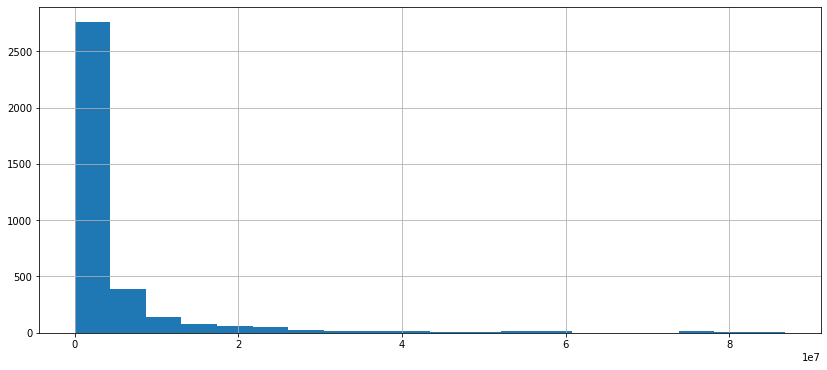

In [23]:
# DO WE NEED THIS?!!?!??!!?!?!?!?!?

#sort country data from highest
merged_country_df.sort_values("TouristNumber",inplace=True, ascending=False)
#plot histogram?
merged_country_df["TouristNumber"].hist(bins=20, figsize=[14,6])

In [24]:
# DO WE NEED THIS?!!?!??!!?!?!?!?!?

#filter data over more than 1 Quartile for both number of tourists and volume of tourism receipts
filtereddata=merged_country_df[merged_country_df['TouristNumber']>= 0.2*10**6]
filtereddata=filtereddata[filtereddata['Receipt']>= 135*10**6]
#filtereddata.describe()

## STEP 5: Visualisations

In this section several visualisation tools will be used on the raw data in order to see trends for the variables of interest. This will help in getting a better idea on which regions/income groups/countries to focus the more detailed analysis.

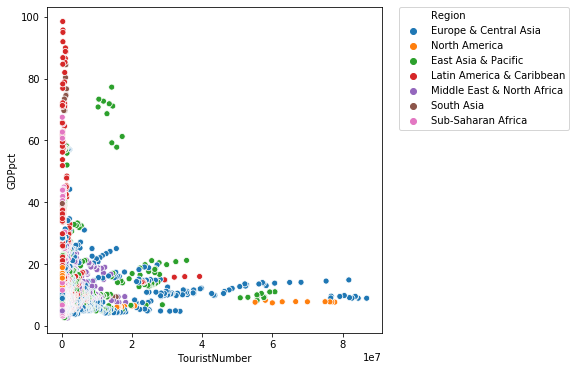

In [25]:
# filter on data from 2007 and onwards
yrs  = filtereddata[filtereddata['Year'] > '2007-01-01']

# resize figure
fig = plt.figure(figsize=(6,6))

# call a seaborn scatterplot to investigate the relationship between Tourist Number and Tourist expenditure as % of total GDP
ax = sns.scatterplot(x="TouristNumber",
                     y="GDPpct",
                     data=yrs,
                     hue="Region")

ax.legend(bbox_to_anchor=(1.05, 1),
          loc=2,
          borderaxespad=0.)

plt.show()

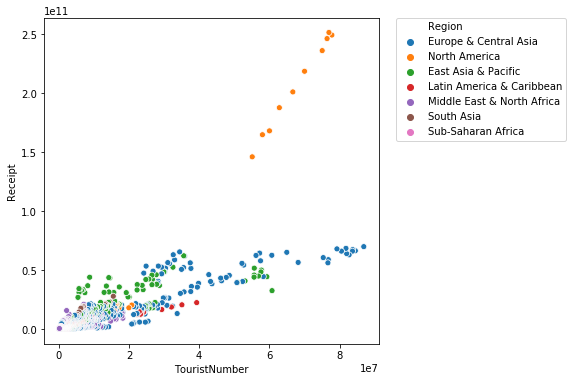

In [26]:
# resize figure
fig = plt.figure(figsize=(6,6))

# call a seaborn scatterplot to investigate the relationship between Tourist Number and Tourist expenditure
ax = sns.scatterplot(x="TouristNumber",
                     y="Receipt",
                     data=yrs,
                     hue="Region")

ax.legend(bbox_to_anchor=(1.05, 1),
          loc=2,
          borderaxespad=0.)
plt.show()

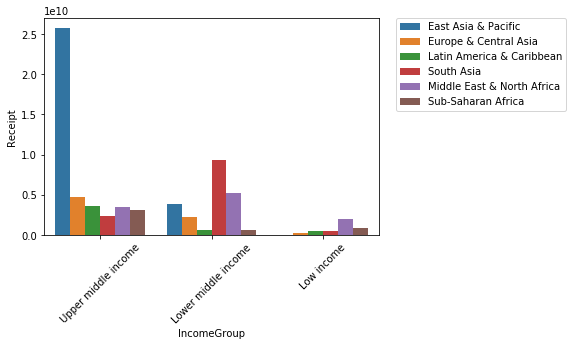

In [27]:
# call a seaborn barplot to investigate the tourist expenditure based on Income Group (High Income group excluded) and Region
ax = sns.barplot(x="IncomeGroup",
                 y="Receipt",
                 data=yrs[yrs["IncomeGroup"] != "High income"],
                 ci=None,
                 hue='Region')


ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45)

ax.legend(bbox_to_anchor=(1.05, 1),
          loc=2,
          borderaxespad=0.)

plt.show()

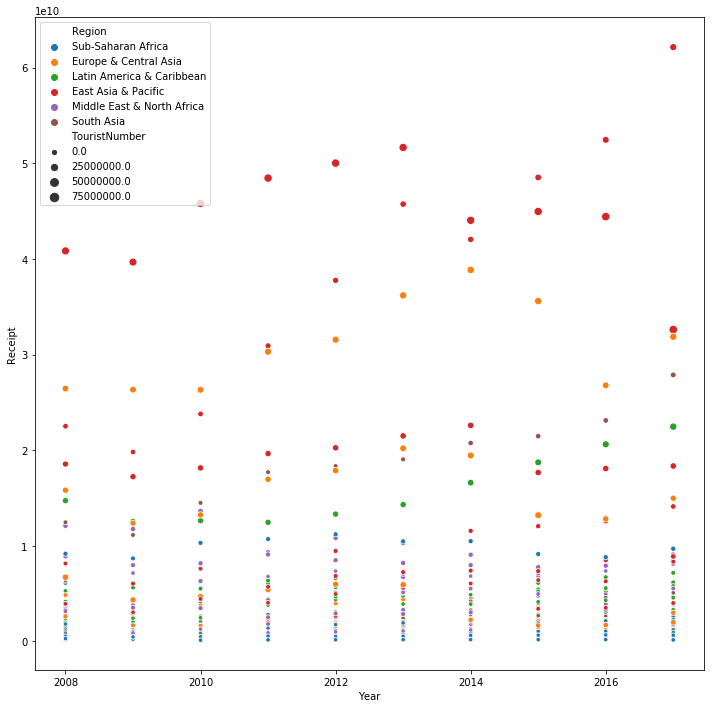

In [28]:
# resize figure
fig = plt.figure(figsize=(12,12))

# call a seaborn scatterplot to investigate the evolution of Tourist expenditure over time, summarized by Income Group 
#(exlcuding High Income Group)
ax = sns.scatterplot(x=yrs["Year"].dt.year,
                     y="Receipt", data=yrs[yrs["IncomeGroup"] != "High income"],
                     hue="Region",
                     size="TouristNumber")

plt.show()

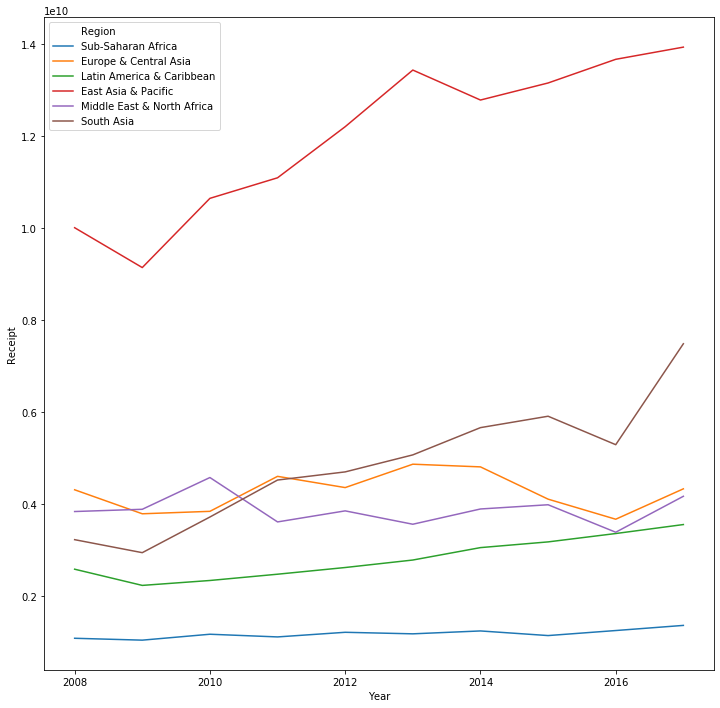

In [29]:
# resize figure
fig = plt.figure(figsize=(12,12))

# call a seaborn lineplot to investigate the evolution of Tourist expenditure over time, summarized by Region
ax = sns.lineplot(x=yrs["Year"].dt.year,
                  y="Receipt",
                  data=yrs[yrs["IncomeGroup"] != "High income"],
                  ci=None,
                  hue="Region")

Many of these visualizations have excluded High Income Regions, because these countries usually have a very developed and competitive tourist market. Implying that there are high boundaries to enter and low marginal returns.

Based on these visualizations we have decided to focus our study on: 

In [30]:
#filter the data by both Income Group and Region set in the list variables to focus our analysis
income_filter=['Upper middle income']
region_filter =['East Asia & Pacific']
incomefilter=filtereddata.loc[filtereddata['IncomeGroup'].isin(income_filter)]['Country Code']
regionfilter=filtereddata.loc[filtereddata['Region'].isin(region_filter)]['Country Code']
bothfilter=set(incomefilter.values).intersection(set(regionfilter.values))
print("Focus countries:{}".format(bothfilter))
filtered_country_df=filtereddata[filtereddata['Country Code'].isin(bothfilter)]
filtered_country_df.describe()

Focus countries:{'MYS', 'THA', 'CHN', 'FJI'}


TouristNumber       Receipt    Population  StartupSteps     GDPpct  \
count   7.200000e+01  7.200000e+01  7.200000e+01     72.000000  72.000000   
mean    2.219374e+07  1.972181e+10  3.553114e+08      7.960225  19.203036   
std     1.898724e+07  1.687050e+10  5.654875e+08      1.739175  10.456504   
min     2.940000e+05  2.910000e+08  8.110060e+05      5.000000   8.237930   
25%     7.395000e+06  4.701750e+09  1.761506e+07      6.518225  12.245100   
50%     1.838850e+07  1.801650e+10  4.702884e+07      8.000000  15.160750   
75%     3.264000e+07  3.134725e+10  3.675686e+08     10.000000  22.922450   
max     6.074000e+07  6.215800e+10  1.386395e+09     11.000000  40.553700   

            GDPgovt  GDPgovtpct        GDPcap  
count  7.200000e+01   72.000000  7.200000e+01  
mean   1.224427e+06    5.288163  2.565947e+07  
std    2.268850e+06    4.452541  4.323711e+07  
min    1.000000e+04    1.652370  8.000000e+04  
25%    2.750000e+04    2.422312  2.310341e+06  
50%    9.755800e+04    3.252425  5.278970e+06  
75%    7.260737e+05    6.116263  1.515688e+07  
max    9.030130e+06   13.186800  1.546660e+08

    Explained_Var  Cumulative_Var
PC                               
1            65.9           65.93
2            18.2           84.08
3             8.8           92.86
4             4.7           97.53
5             1.5           99.02
6             0.4           99.45
7             0.3           99.76
8             0.2          100.00


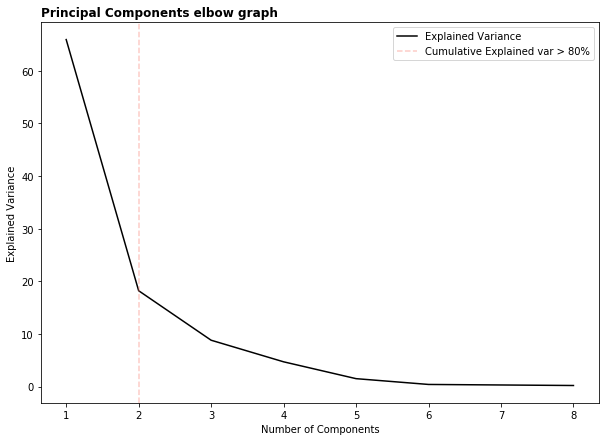

[5.3 1.5 0.7 0.4 0.1 0.  0.  0. ]
     TouristNumber   Receipt  Population  StartupSteps    GDPpct   GDPgovt  \
PC1       0.428284  0.365570    0.381834     -0.263588 -0.343395  0.376730   
PC2       0.000615 -0.137058    0.296151      0.026544  0.455942  0.360683   
PC3      -0.063740  0.048223   -0.052535     -0.941291  0.134135 -0.170242   
PC4       0.142586  0.833981   -0.315304      0.147927  0.375471 -0.068538   
PC5      -0.144171 -0.156912   -0.716134     -0.143530  0.071336  0.445713   
PC6       0.258869 -0.111224   -0.090113     -0.002958  0.038803 -0.697177   
PC7       0.836721 -0.324755   -0.217203      0.011505  0.175988  0.097161   
PC8       0.065414  0.085246   -0.310122      0.034104 -0.691130  0.012091   

     GDPgovtpct    GDPcap  
PC1   -0.246499  0.383468  
PC2    0.665310  0.334951  
PC3    0.161179 -0.178521  
PC4    0.116332 -0.060315  
PC5   -0.208238  0.417172  
PC6    0.040911  0.650579  
PC7    0.019439 -0.326088  
PC8    0.641619 -0.040425  

 PCA is no

In [31]:
#perform PCA on the filtered country data
# Normalize
clust = filtered_country_df.copy().drop(columns=["Country Name",'Country Code','Year',"Region","IncomeGroup"])

scaler = StandardScaler()

clust = scaler.fit_transform(clust)

clust = pd.DataFrame(clust, columns =filtered_country_df.drop(columns=["Country Name",'Country Code','Year',"Region","IncomeGroup"]).columns)

n_components = clust.shape[1]

pca = PCA(n_components= n_components)

principalComponents = pca.fit_transform(clust)

# Explained variance by each component

pca_board = pd.DataFrame({"Explained_Var":np.round(pca.explained_variance_ratio_*100,decimals=1),
                          "Cumulative_Var":np.round(np.cumsum(pca.explained_variance_ratio_*100),decimals= 2)})
pca_board.index.name = 'PC'
pca_board.index += 1 

print (pca_board)

#elbow graph
plt.figure(figsize=(10,7))
plt.plot(pca_board.Explained_Var, color = "black", label = "Explained Variance")
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title ("Principal Components elbow graph", loc = "left",fontweight = "bold")
plt.axvline(x = 2, alpha = 0.4, color = "salmon", linestyle = "--", label = "Cumulative Explained var > 80%")
plt.legend()
plt.show()

print(np.round(pca.explained_variance_,decimals=1))

'''2 components'''

# Revert PCA effect
# pca.inverse_transform(principalComponents)

pca_index= []

for i in range(1,n_components+1):
    pca_index.append('PC'+str(i))
    
print (pd.DataFrame(pca.components_,
                    columns=clust.columns,
                    index = pca_index))


agg_pca = pd.DataFrame(principalComponents,
                     columns = pca_index)


print("\n PCA is not a good option")

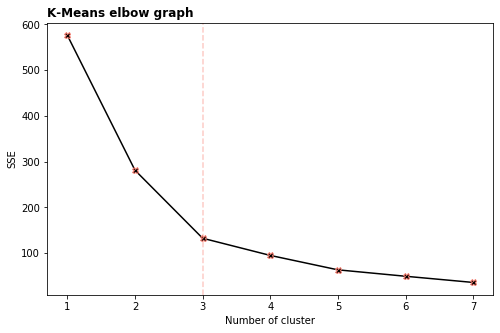

      Inertia
1  576.000000
2  281.069743
3  132.345477
4   94.784483
5   63.250309
6   49.209687
7   35.679963


In [32]:
#run elbow plot for range of k_max
k_max = 8
elbow_plot(clust,k_max)

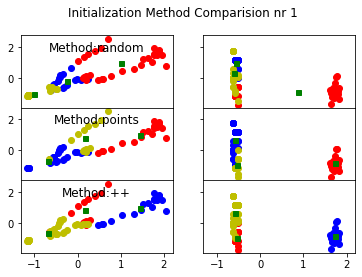

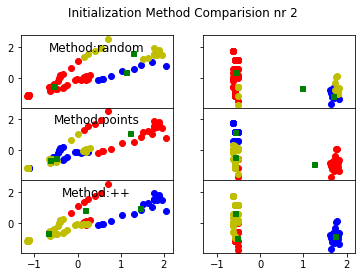

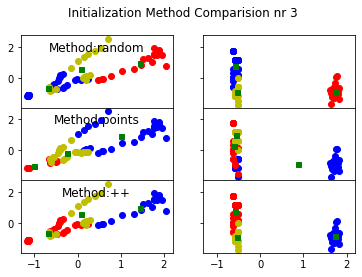

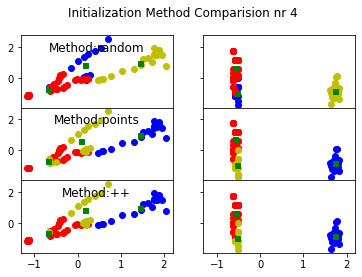

In [33]:
#run different initialisation methods and optimal k value(elbow)

init_methods = ['random','points','++']
number_K=3

keys, centroids_list, labels_list = compare_init_methods(clust.iloc[:,0:4].values,init_methods,number_K)

In [34]:
#pick best kmeans iteration and initialisation method from plots above (please chnage accordingly)
best_init=3
best_method="points"

centroids_dict=dict(zip(keys,centroids_list))
labels_dict =dict(zip(keys,labels_list))
print(" Labels: \n {} \n Centroids: \n {}".format(labels_dict["{}:{}".format(best_init,best_method)], centroids_dict["{}:{}".format(best_init,best_method)]))


 Labels: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 2 2 0 2 2 2 2
 2 2 2 2 2 2 2 1 1 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 
 Centroids: 
 [[ 1.00079532  0.95915368  0.86786028 -0.89332898]
 [-1.00621302 -1.01512373 -0.61219318  0.31330566]
 [-0.25652377 -0.18170985 -0.5513322   0.96774761]]


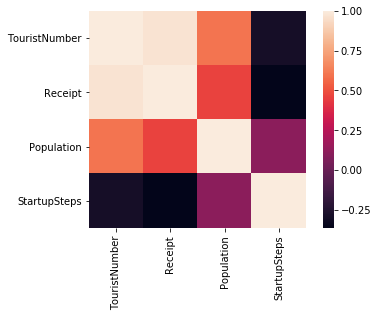

In [35]:
merged_region_df_cr = merged_region_df[['Country Name','TouristNumber','Receipt','Population', 'StartupSteps']] #Subsetting the data
cor = merged_region_df_cr.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

In [36]:
fig = go.Figure(data=go.Choropleth(
    locations = merged_country_df['Country Code'],
    z = merged_country_df['TouristNumber'],
    text = merged_country_df['Country Name'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Tourist<br>Number',
))

fig.update_layout(
    title_text='Tourist Number',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        showarrow = False
    )]
)

fig.show()

In [37]:
#filter the data by both Income Group and Region set in the list variables to focus our analysis
income_filter=['Upper middle income']
region_filter =['South Asia']
incomefilter=filtereddata.loc[filtereddata['IncomeGroup'].isin(income_filter)]['Country Code']
regionfilter=filtereddata.loc[filtereddata['Region'].isin(region_filter)]['Country Code']
bothfilter=set(incomefilter.values).intersection(set(regionfilter.values))
print("Focus countries:{}".format(bothfilter))
filtered_country_df=filtereddata[filtereddata['Country Code'].isin(bothfilter)]
filtered_country_df.describe()

Focus countries:{'LKA', 'MDV'}


TouristNumber       Receipt    Population  StartupSteps     GDPpct  \
count   3.600000e+01  3.600000e+01  3.600000e+01     36.000000  36.000000   
mean    8.471222e+05  1.608306e+09  1.019980e+07      7.337289  33.262451   
std     4.762988e+05  1.247943e+09  9.989488e+06      1.859342  28.844725   
min     3.370000e+05  3.210000e+08  2.793980e+05      5.000000   6.859420   
25%     4.917500e+05  7.240000e+08  3.509115e+05      6.000000   9.229823   
50%     6.550000e+05  1.328000e+09  9.637002e+06      7.000000  14.091750   
75%     1.145000e+06  2.443000e+09  2.001886e+07      9.000000  69.653250   
max     2.116400e+06  5.083000e+09  2.144400e+07     12.030710  84.480500   

            GDPgovt  GDPgovtpct         GDPcap  
count     36.000000   36.000000      36.000000  
mean   22777.777778    9.636185  363276.916667  
std    13007.934087    5.310748  291270.248937  
min    10000.000000    4.289810   30000.000000  
25%    10000.000000    4.408432  109399.750000  
50%    20000.000000    9.482115  226123.500000  
75%    30000.000000   14.861350  628095.000000  
max    50000.000000   15.287000  938008.000000

In [38]:
merged_region_df.groupby('Country Name').Receipt.mean()

Country Name
Arab World                                              5.713004e+10
Caribbean small states                                  7.515191e+09
Central Europe and the Baltics                          4.272022e+10
Early-demographic dividend                              1.328415e+11
East Asia & Pacific                                     2.274951e+11
East Asia & Pacific (IDA & IBRD countries)              9.886516e+10
East Asia & Pacific (excluding high income)             9.890417e+10
Euro area                                               2.934506e+11
Europe & Central Asia                                   4.596061e+11
Europe & Central Asia (IDA & IBRD countries)            7.144070e+10
Europe & Central Asia (excluding high income)           5.358655e+10
European Union                                          3.896566e+11
Fragile and conflict affected situations                1.412126e+10
Heavily indebted poor countries (HIPC)                  9.757960e+09
High income          

# Spectral Clustering

Deciding a set of countries to start the cluster analysis

Based on the following chart, it's possible to determine that Europe & Central Asia has a stable ascending trend during the last years besides the other regions, which is a good indicator for investment. 

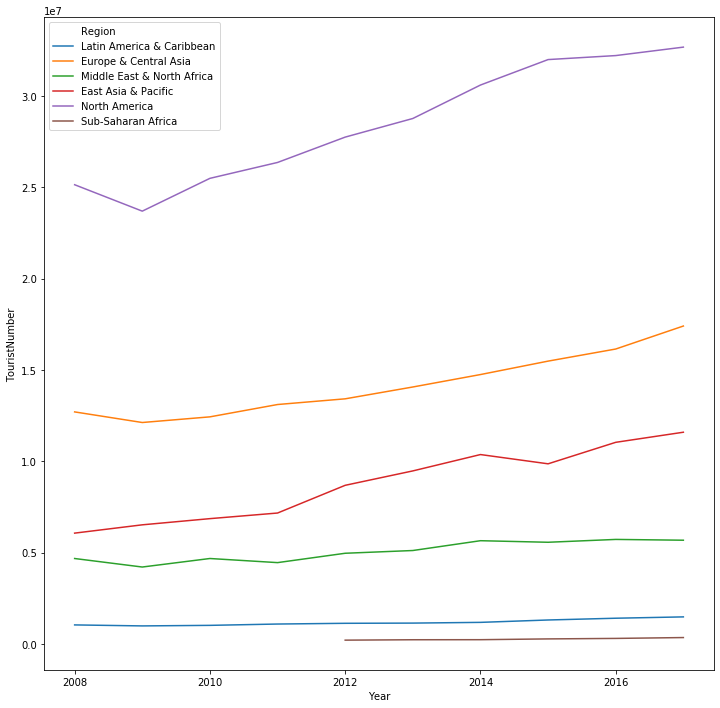

In [90]:
# Plotting the number of tourist arraivals per region, 
# only on high income countries

fig = plt.figure(figsize=(12,12))
ax = sns.lineplot(x = yrs["Year"].dt.year, 
                  y = "TouristNumber", 
                  data = yrs[yrs["IncomeGroup"] == "High income"],
                  ci = None, 
                  hue = "Region")

Filter the dataset according to the previous decision and showing the set of countries selected for the cluster analysis, by their corresponding country code.

In [91]:
# Filtering the data by both Income Group and Region
income_filter = ['Upper middle income']    # Upper middle income, High income
region_filter = ['Europe & Central Asia']    # East Asia & Pacific, Europe & Central Asia

incomefilter = merged_country_df.loc[merged_country_df['IncomeGroup'].isin(income_filter)]['Country Code']
regionfilter = merged_country_df.loc[merged_country_df['Region'].isin(region_filter)]['Country Code']
bothfilter = set(incomefilter.values).intersection(set(regionfilter.values))

# Print selected countries codes
print("Focus countries:{}".format(bothfilter))

# Define a pandas DataFrame with the filtered information
filtered_country_df = filtereddata[filtereddata['Country Code'].isin(bothfilter)]
filtered_country_df.describe()

Focus countries:{'RUS', 'KAZ', 'TKM', 'GEO', 'ARM', 'MKD', 'ROU', 'MNE', 'ALB', 'BGR', 'TUR', 'SRB', 'BLR', 'AZE', 'BIH'}


TouristNumber       Receipt    Population  StartupSteps      GDPpct  \
count   2.090000e+02  2.090000e+02  2.090000e+02    209.000000  209.000000   
mean    6.848104e+06  4.171234e+09  2.483384e+07      7.872512   11.304323   
std     9.494913e+06  7.489105e+09  4.119964e+07      3.136459    6.407256   
min     2.020000e+05  1.360000e+08  6.150250e+05      2.000000    2.875970   
25%     7.580000e+05  6.800000e+08  3.039616e+06      6.000000    5.598440   
50%     2.857000e+06  1.230000e+09  7.395599e+06      7.000000   10.711000   
75%     7.311000e+06  2.855000e+09  1.970233e+07     10.000000   14.143500   
max     3.981100e+07  3.885500e+10  1.465966e+08     15.000000   31.336100   

             GDPgovt  GDPgovtpct        GDPcap  
count     209.000000  209.000000  2.090000e+02  
mean   132624.550942    2.525061  2.038132e+06  
std    265244.961581    1.286191  3.584997e+06  
min         0.000000   -0.010000  2.000000e+04  
25%      6105.295826    1.089390  1.637450e+05  
50%     20000.000000    2.936750  2.699370e+05  
75%     70000.000000    3.665290  1.924720e+06  
max    996149.000000    4.572846  2.052610e+07

Step 2: Loading and Cleaning the Data

In [92]:
# Loading the data
X = filtered_country_df 
  
# Dropping non-numeric columns 
X = X.drop(['Country Name',
            'Country Code',
            'Year',
            'Region',
            'IncomeGroup'],
            axis = 1) 

# Showing the cleaned data stored in X
X.head()

TouristNumber       Receipt  Population  StartupSteps   GDPpct  \
3684     39811000.0  3.885500e+10  77231907.0          11.0  12.1968   
3931     39478000.0  3.559700e+10  78529409.0          11.0  11.9867   
3437     37795000.0  3.619200e+10  75928564.0          10.0  11.5057   
4425     37601000.0  3.187000e+10  81101892.0          10.0  11.6110   
3190     35698000.0  3.156600e+10  74653016.0          10.0  11.1709   

       GDPgovt  GDPgovtpct      GDPcap  
3684  750140.0     1.71942  15878600.0  
3931  788456.0     1.74322  16686500.0  
3437  711160.0     1.61775  12581700.0  
4425  890927.0     1.71526  20526100.0  
3190  656900.0     1.51965  11011500.0

Step 3: Determine the number of components needed to explain a reasonable percentage of the total variance using Principal Components Analysis (PCA).

In [93]:
# Scaling the Data 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
# Normalizing the Data 
X_normalized = normalize(X_scaled) 

# Fitting the PCA algorithm with our Data
pca = PCA().fit(X_scaled)

# Showing the percentage explained by each compomonent and 
# and the cumulative sum of this percentage on a table
pca_board = pd.DataFrame({"Explained var. (%)":np.round(pca.explained_variance_ratio_*100, decimals = 1),
                          "Cumulative var. (%)":np.round(np.cumsum(pca.explained_variance_ratio_*100), decimals = 2)})
pca_board.index.name = 'PC'
pca_board.index += 1 

print (pca_board)

    Explained var. (%)  Cumulative var. (%)
PC                                         
1                 56.5                56.46
2                 16.6                73.08
3                 12.6                85.68
4                  8.5                94.19
5                  4.0                98.22
6                  1.0                99.17
7                  0.5                99.71
8                  0.3               100.00


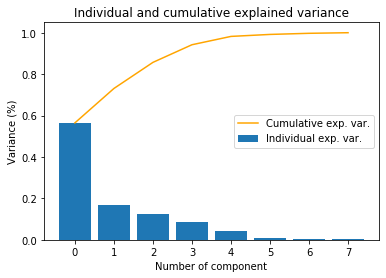

In [82]:
# Plotting the Cumulative Sum of the Explained Variance
plt.figure()

plt.plot(np.cumsum(pca.explained_variance_ratio_), 
         color = 'orange', 
         label = 'Cumulative exp. var.')

x_pos = np.arange(len(pca.explained_variance_ratio_))
plt.bar(x_pos,pca.explained_variance_ratio_,        
        label = 'Individual exp. var.')

plt.xlabel('Number of component')
plt.ylabel('Variance (%)') # for each component
plt.title('Individual and cumulative explained variance')
plt.legend(loc = 'center right', frameon = True)
plt.show()


Step 4: Preprocessing the data (reducing dimmensions) to make it visualizable with PCA, based on the step 3 conclusions

In [83]:
# Reducing the dimensions of the data with PCA
n_PC = 3  # Define the numbers of components
pca = PCA(n_components = n_PC) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['PC' + str(x) for x in range(1,n_PC + 1)] 
  
X_principal.head()

PC1       PC2       PC3
0  0.890442 -0.686390  0.296363
1  0.902416 -0.688839  0.296538
2  0.904292 -0.689430  0.260648
3  0.904882 -0.693444  0.251437
4  0.929071 -0.672517  0.263949

Step 5: Determine the number of clusters

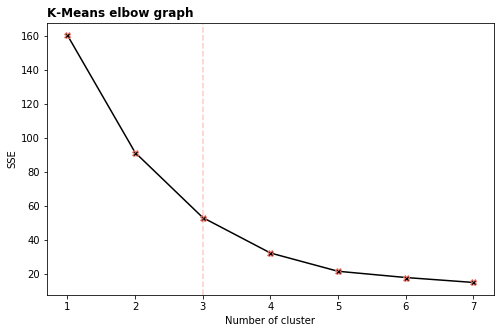

      Inertia
1  160.178409
2   91.383938
3   53.187039
4   32.390842
5   21.661646
6   17.994912
7   15.097875


In [84]:
# Showing scree plot to determine the correct number of clusters
elbow_plot(X_principal,8)

Step 6: Building the Clustering models and Visualizing the clustering.

The Spectral Clustering Method can be developed with 2 types of affinity.
We will use both types and compare the results to choose the best

a) Using affinity = ‘rbf’

Kernel of the euclidean distanced

In [85]:
# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 3, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

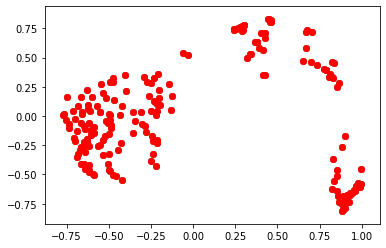

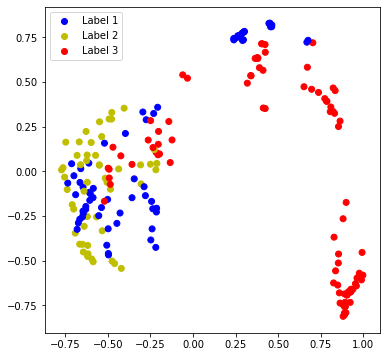

In [86]:
# Building the label to colour mapping 
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_rbf] 
  
# Plotting the clustered scatter plot 
  
b = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='b'); 
y = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='y');
r = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='r');
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['PC1'], X_principal['PC2'], c = cvec) 
plt.legend((b, y, r), ('Label 1', 'Label 2','Label 3'))

plt.show() 

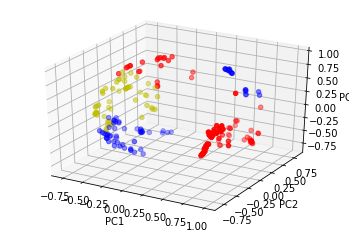

In [87]:
# 3D plot for 3 Principal Components reduction
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt


# Building the label to colour mapping
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'

# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_rbf] 

# Plotting the clustered scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

xs = [X_principal['PC1']]
ys = [X_principal['PC2']]
zs = [X_principal['PC3']]

ax.scatter(xs, ys, zs, c = cvec, marker = 'o') 

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

b) Using affinity = ‘nearest_neighbors’

In [88]:
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 3, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal) 

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



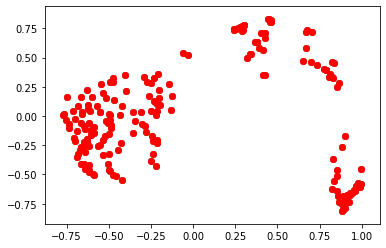

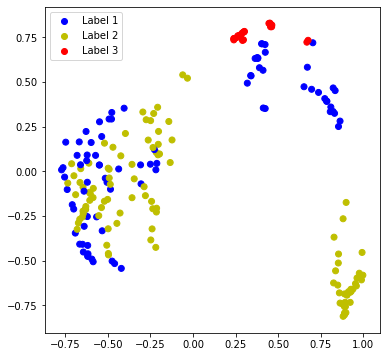

In [50]:
# Building the label to colour mapping 
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_nn] 
  
# Plotting the clustered scatter plot 
  
b = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='b'); 
y = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='y');
r = plt.scatter(X_principal['PC1'], X_principal['PC2'], color ='r');
  
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['PC1'], X_principal['PC2'], c = cvec) 
plt.legend((b, y, r), ('Label 1', 'Label 2','Label 3'))

plt.show() 

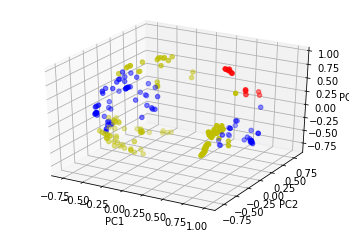

In [51]:
# 3D plot for 3 Principal Components reduction
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt


# Building the label to colour mapping
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'

# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_nn] 

# Plotting the clustered scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

xs = [X_principal['PC1']]
ys = [X_principal['PC2']]
zs = [X_principal['PC3']]

ax.scatter(xs, ys, zs, c = cvec, marker = 'o') 

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

Step 7: Evaluating and comparing the performances of both affinity methods

In [52]:
# List of different values of affinity 
affinity = ['rbf', 'nearest-neighbours'] 
  
# List of Silhouette Scores 
s_scores = [] 
  
# Evaluating the performance 
s_scores.append(silhouette_score(X, labels_rbf)) 
s_scores.append(silhouette_score(X, labels_nn)) 
  
print(s_scores) 

[-0.19427623525892326, -0.30899813854519353]


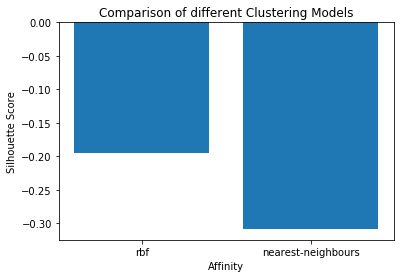

In [53]:
# Plotting a Bar Graph to compare the models 
plt.bar(affinity, s_scores) 
plt.xlabel('Affinity') 
plt.ylabel('Silhouette Score') 
plt.title('Comparison of different Clustering Models') 
plt.show() 

Acording to Peter Rousseeuw[1], silhouette shows which objects lie well within their cluster, and which ones are merely somewhere in between clusters. The silhouette scores s(i) are measured on the following range of values: 
-1 <= s(i) <= 1

Breifly, about this values:
a silhouette score close to 1 means 'well-clustered’
a silhouette score close to 0 is considered as 'intermediate case’
a silhouette score close to -1 means 'misclassified’

[1] Silhouettes: A graphical aid to the interpretation and validation of cluster analysis https://www.sciencedirect.com/science/article/pii/0377042787901257?via%3Dihub

## Regression Model

In [54]:
is_east_asia_pacific_df = merged_country_df['Region']=='East Asia & Pacific'
east_asia_pacific_df = merged_country_df[is_east_asia_pacific_df]

In [55]:
corr = east_asia_pacific_df.corr(method='pearson')
corr

TouristNumber   Receipt  Population  StartupSteps    GDPpct  \
TouristNumber       1.000000  0.849992    0.791229     -0.167833 -0.148379   
Receipt             0.849992  1.000000    0.501269     -0.299800 -0.097419   
Population          0.791229  0.501269    1.000000     -0.028163 -0.186274   
StartupSteps       -0.167833 -0.299800   -0.028163      1.000000 -0.068233   
GDPpct             -0.148379 -0.097419   -0.186274     -0.068233  1.000000   
GDPgovt             0.676749  0.586547    0.721673     -0.173576 -0.219114   
GDPgovtpct         -0.274001 -0.300154   -0.167134      0.013952  0.396140   
GDPcap              0.811498  0.617484    0.877374     -0.136243 -0.190209   

                GDPgovt  GDPgovtpct    GDPcap  
TouristNumber  0.676749   -0.274001  0.811498  
Receipt        0.586547   -0.300154  0.617484  
Population     0.721673   -0.167134  0.877374  
StartupSteps  -0.173576    0.013952 -0.136243  
GDPpct        -0.219114    0.396140 -0.190209  
GDPgovt        1.000000   -0.236037  0.881567  
GDPgovtpct    -0.236037    1.000000 -0.206850  
GDPcap         0.881567   -0.206850  1.000000

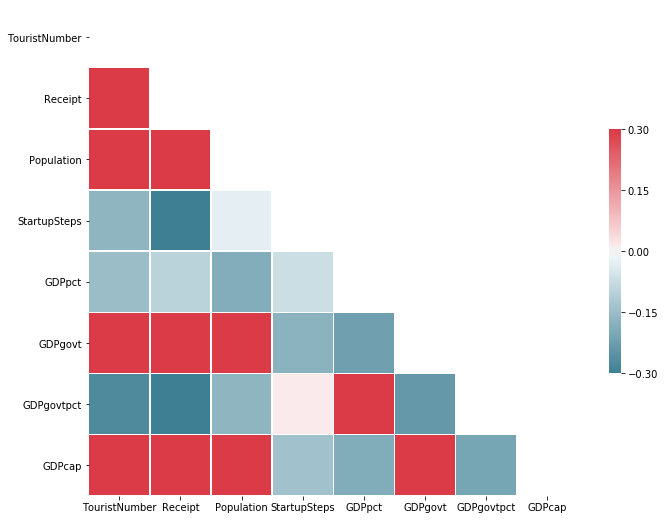

In [56]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



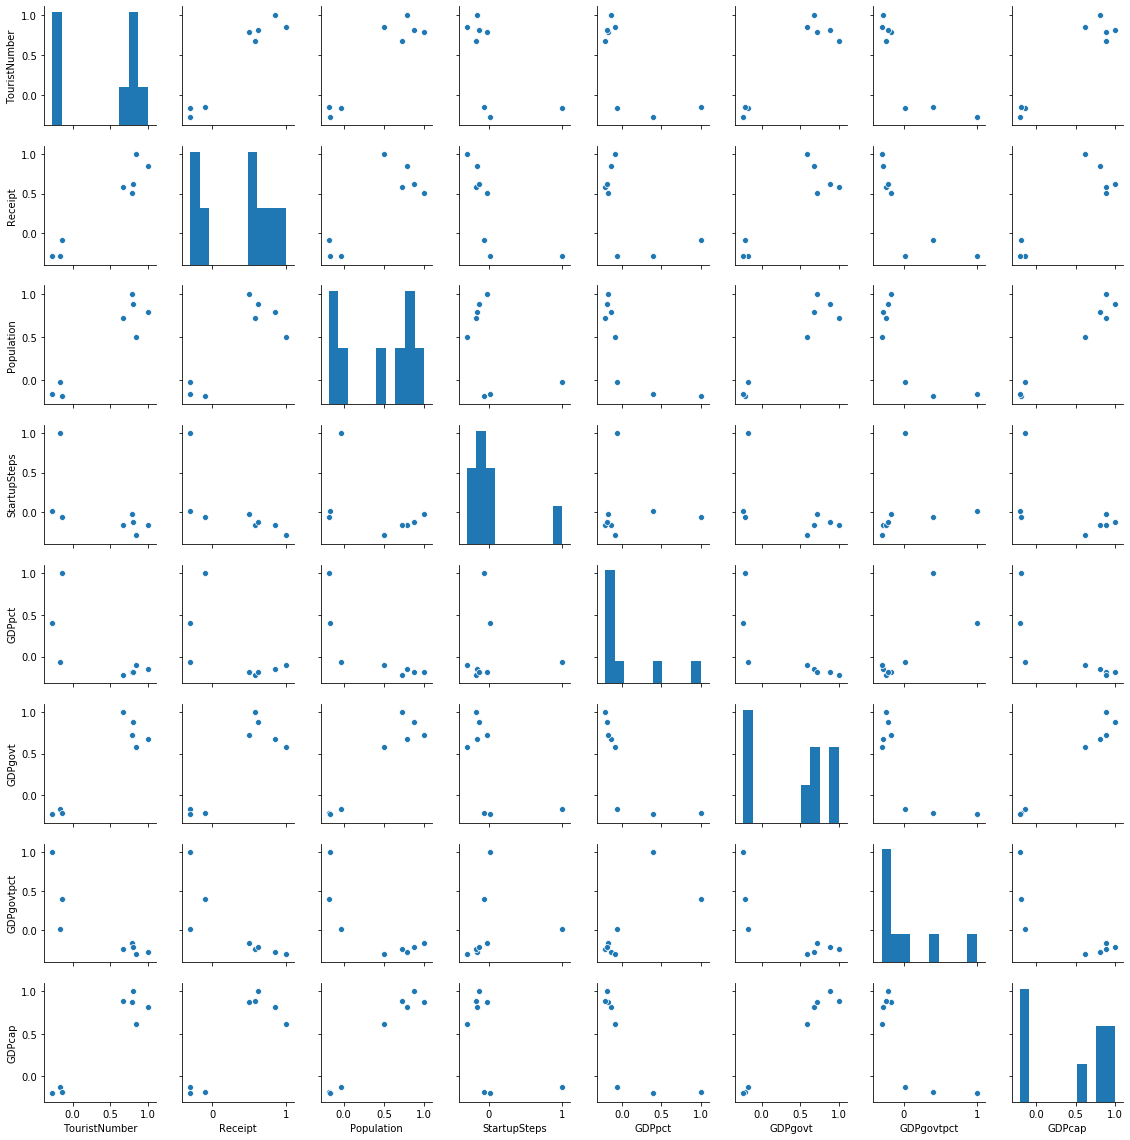

In [57]:
sns.pairplot(data=corr, size = 2)

In the first model (model1), we analyzed all of the variables.

Proceeding to an in-depth analysis of the model, it is observed that the target variable has 91% of its variations explained, which is a very high r-squared. #atencao r-squared demasiado grande!!!!!!!!
However not all of the variables are statictically significant at the 0.05 level, since their p-value is greater than .05. For this reason, we created a second model without those.

In [58]:
from statsmodels.api import add_constant

In [59]:
#slice data into features X and target y
x = east_asia_pacific_df[['Receipt', 'Population','StartupSteps','GDPpct', 'GDPgovt','GDPgovtpct','GDPcap'] ]
x = sm.add_constant(x)

y = east_asia_pacific_df[ 'TouristNumber' ]   

model1 = sm.OLS(y, x)
results = model1.fit()
results.summary()

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TouristNumber   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     897.4
Date:                Thu, 07 Nov 2019   Prob (F-statistic):          3.37e-320
Time:                        19:44:45   Log-Likelihood:                -10289.
No. Observations:                 630   AIC:                         2.059e+04
Df Residuals:                     622   BIC:                         2.063e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.457e+04   4.36e+05     -0.125      0.900    -9.1e+05    8.01e+05
Receipt          0.0005   1.49e-05     36.789      0.000       0.001       0.001
Population       0.0179      0.001     15.176      0.000       0.016       0.020
StartupSteps  8.861e+04   4.18e+04      2.118      0.035    6466.528    1.71e+05
GDPpct         381.9967   8470.390      0.045      0.964   -1.63e+04     1.7e+04
GDPgovt         -1.7424      0.239     -7.278      0.000      -2.213      -1.272
GDPgovtpct   -2.202e+04   1.67e+04     -1.316      0.189   -5.49e+04    1.08e+04
GDPcap           0.1492      0.023      6.615      0.000       0.105       0.194
==============================================================================
Omnibus:                      158.975   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2322.602
Skew:                           0.684   Prob(JB):                         0.00
Kurtosis:                      12.306   Cond. No.                     4.63e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Multicollinearity (VIF)**

The results for the VIF factors aren’t suprising “Population”, “GDPgovt” and “GDPcap” are  quite high. This happens  because they "explain" the same variance within this dataset. For this reason, we should discard two of these variables. Since “GDPcap” variance inflation factor is much higher then the rest it is the obvious choice to eliminate first. “GDPgovt” is the other variable we should eliminate because we considered the information from "Population" less redundant. ######?????????????????????????????????????????????

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns

In [61]:
vif.round(1)

VIF Factor      features
0        13.1         const
1         1.9       Receipt
2         4.7    Population
3         1.2  StartupSteps
4         1.2        GDPpct
5         4.9       GDPgovt
6         1.3    GDPgovtpct
7        10.5        GDPcap

In [62]:
#slice data into features X and target y
x2 = east_asia_pacific_df[['Receipt', 'Population','StartupSteps','GDPpct', 'GDPgovtpct']  ]
x2 = sm.add_constant(x2)

y = east_asia_pacific_df[ 'TouristNumber' ]   

model2 = sm.OLS(y, x2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TouristNumber   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1143.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):          2.65e-311
Time:                        19:44:45   Log-Likelihood:                -10317.
No. Observations:                 630   AIC:                         2.065e+04
Df Residuals:                     624   BIC:                         2.067e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.701e+05   4.49e+05     -0.825      0.410   -1.25e+06    5.11e+05
Receipt          0.0006   1.44e-05     38.346      0.000       0.001       0.001
Population       0.0217      0.001     32.577      0.000       0.020       0.023
StartupSteps  9.869e+04   4.33e+04      2.280      0.023    1.37e+04    1.84e+05
GDPpct        5506.7803   8776.451      0.627      0.531   -1.17e+04    2.27e+04
GDPgovtpct   -1.564e+04   1.74e+04     -0.897      0.370   -4.99e+04    1.86e+04
==============================================================================
Omnibus:                      149.860   Durbin-Watson:                   1.318
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2177.405
Skew:                           0.615   Prob(JB):                         0.00
Kurtosis:                      12.024   Cond. No.                     4.57e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.57e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
# For each X, calculate VIF and save in dataframe
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(x2.values, i) for i in range(x2.shape[1])]
vif2["features"] = x2.columns

In [64]:
#slice data into features X and target y
x3 = east_asia_pacific_df[['Receipt', 'Population','StartupSteps','GDPgovtpct']  ]
x3 = sm.add_constant(x3)

y = east_asia_pacific_df[ 'TouristNumber' ]   

model3 = sm.OLS(y, x3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TouristNumber   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1430.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):          8.02e-313
Time:                        19:44:45   Log-Likelihood:                -10318.
No. Observations:                 630   AIC:                         2.065e+04
Df Residuals:                     625   BIC:                         2.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.852e+05   4.28e+05     -0.667      0.505   -1.12e+06    5.54e+05
Receipt          0.0006   1.44e-05     38.529      0.000       0.001       0.001
Population       0.0217      0.001     32.896      0.000       0.020       0.023
StartupSteps  9.723e+04   4.32e+04      2.251      0.025    1.24e+04    1.82e+05
GDPgovtpct   -1.144e+04   1.61e+04     -0.711      0.478    -4.3e+04    2.02e+04
==============================================================================
Omnibus:                      148.976   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2168.806
Skew:                           0.607   Prob(JB):                         0.00
Kurtosis:                      12.008   Cond. No.                     4.36e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the second model all of the independent variables are statisticly significant, which combined with a very high Adj. R-squared, means we shouldn't remove any further variable.
Having that said we can proceed to do an in-depth analysis of the model. We can observe that the target variable, (TouristNumber), has 90.1% of its variations explained by the choosen model. 
Furthermore, by analyzing the P-value, we can see that all the variables are statistically significant at a 5% significance level. 
As we can see from the coeficients of the model, StartupSteps is the variable that most influences the tourist numbers, which is quite suprising. Meaning for each extra step to upon a start up the number of tourist increases, in average, in 9.48 Million tourists. Also something suprising is that for each percentage increase in the GDPgovtpct, it is expected that the number of tourists decreases in rouglhy 1 million tourists.

Considering the results we can conclude that model regression isn't a good technique to measure the best country/region to invest. This maybe mainly because "tourist number" might not be a good proxy to predict what we're looking for.

## Time Series Analysis

The analysis of time series is based on the assumption that successive values in a set of data represent consecutive measurements taken at equally spaced time intervals.


There are two main goals of time series analysis: (**1**) identifying the nature of the phenomenon represented by the sequence of observations and (**2**) forecasting future values of the time series variable. Both of these goals require that the pattern of observed time series data is identified and more or less formally described. Once the pattern is established, we can interpret and integrate it with other data. 

There are several methods to implement time series analysis in a dataset. One of the most popular ones, which will be used in this project is the **Auto Regressive Integration Moving Average** (**ARIMA**) model.

The ARIMA model is classified as an **ARIMA (p,d,q)** model where:
1. **p** is the number of autoregressive terms
2. **d** is the number of non seasonal differences needed for stationarity
3. **q** s the number of lagged forecast errors in the prediction equation

The assumptions of the model are:
1. The data series used in the model should be stationary
    2. Dickey-Fuller test can be used for testing the stationarity of a dataset
    3. It can be visually represented with a moving average and standard deviation graph

2. The data should be univariate

## Process Steps

1. Country USA is selected and tweaked to be ready for ARIMA forecasting analysis.

Note: the original dataframe is not selected because it has been limited to year 2000 for the previous analyses. As for Timeseries analysis model it is better to include more historical data for better predictive model, hence the reason the dataframe has been extended to include all years available

In [65]:
# Reading the data again to format it correctly for timeseries analysis
timeseries = clean_data(raw_receipt,["Indicator Name", "Indicator Code"],2,drop_years=False)
timeseries = unpivot(timeseries, ['Country Name', 'Country Code'], 'Year', 'Receipt')

In [66]:
# filtering out the necessary variables for the focus of the analysis

trial = timeseries[['Year','Receipt']][timeseries['Country Code']=='USA']
trial['Year'] = pd.to_datetime(trial.Year, format='%Y')
trial.set_index('Year',inplace=True)
trial

Receipt
Year                    
1995-01-01  9.374300e+10
1996-01-01  1.021960e+11
1997-01-01  1.070470e+11
1998-01-01  1.050950e+11
1999-01-01  1.114750e+11
2000-01-01  1.209120e+11
2001-01-01  1.091030e+11
2002-01-01  1.044270e+11
2003-01-01  1.015350e+11
2004-01-01  1.156890e+11
2005-01-01  1.220770e+11
2006-01-01  1.267780e+11
2007-01-01  1.442230e+11
2008-01-01  1.647210e+11
2009-01-01  1.460020e+11
2010-01-01  1.679960e+11
2011-01-01  1.876290e+11
2012-01-01  2.009970e+11
2013-01-01  2.184960e+11
2014-01-01  2.359900e+11
2015-01-01  2.491830e+11
2016-01-01  2.461720e+11
2017-01-01  2.513610e+11

2. Plotting the data to see the trend over the years visually

C:\Users\Lenovo\Documents\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



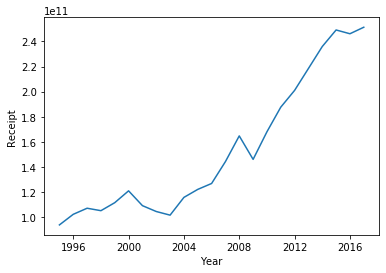

In [67]:
plt.xlabel('Year')
plt.ylabel('Receipt')
plt.plot(trial)

3. In the bellow cell we transform the data using the squere root function to shift the data towards stationariry assumption.

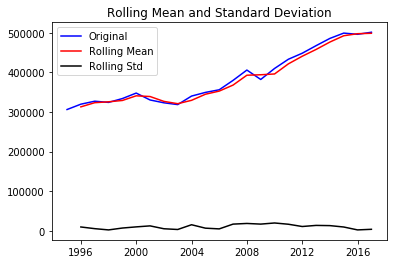

Results of Dickey-Fuller Test:
Test Statistic                  -3.353548
p-value                          0.012648
#Lags Used                       9.000000
Numbers of observations used    13.000000
Critical Value (1%)             -4.068854
Critical Value (5%)             -3.127149
Critical Value (10%)            -2.701730
dtype: float64


In [68]:
trial_sqrtScale = np.sqrt(trial)
trial_sqrtScale.dropna(inplace=True)

test_stationarity(trial_sqrtScale, 'Receipt')

The following transformations include additional tests for checking the stationarity of the data studied

In [69]:
#moving average and standard deviation functions with a 2 year window
movingAverage = trial_sqrtScale.rolling(window=2).mean()
movingSTD = trial_sqrtScale.rolling(window=2).std()

# another test for checking the stationarity of the data
datasetLogScaleMinusMovingAverage = trial_sqrtScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

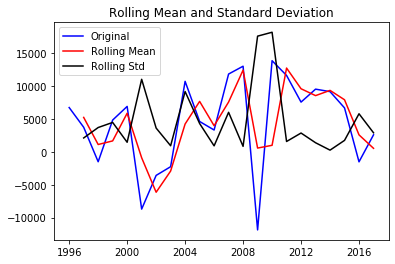

Results of Dickey-Fuller Test:
Test Statistic                  -3.353548
p-value                          0.012648
#Lags Used                       9.000000
Numbers of observations used    13.000000
Critical Value (1%)             -4.068854
Critical Value (5%)             -3.127149
Critical Value (10%)            -2.701730
dtype: float64


In [70]:
test_stationarity(datasetLogScaleMinusMovingAverage,'Receipt')

Note: the data is not of the highest quality for time series analysis. Especially since the timeseries data contains values only at the end of each year, instead of month-wise intervals. This removes the seasonality feature from the model and makes it more difficult for ARIMA to forecast future values. Even though the performed tests imply stationarity, it can still be used to make predictions with the ARIMA model.

4. In this point we are making sure the data is in timeseries format and ready for the ARIMA model analysis 

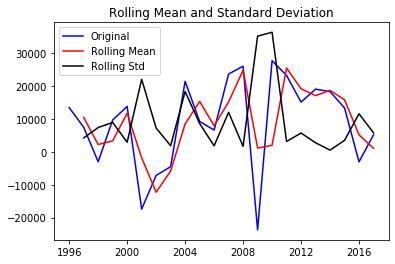

Results of Dickey-Fuller Test:
Test Statistic                  -3.353548
p-value                          0.012648
#Lags Used                       9.000000
Numbers of observations used    13.000000
Critical Value (1%)             -4.068854
Critical Value (5%)             -3.127149
Critical Value (10%)            -2.701730
dtype: float64


In [71]:
# shifting the values into a timeseries so they can be used in the forecast

datasetLogDiffShifting = trial_sqrtScale - trial_sqrtScale.shift()
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting,'Receipt')

5. A visualization to check for the trend, seasonal adjustments and residuals in the data

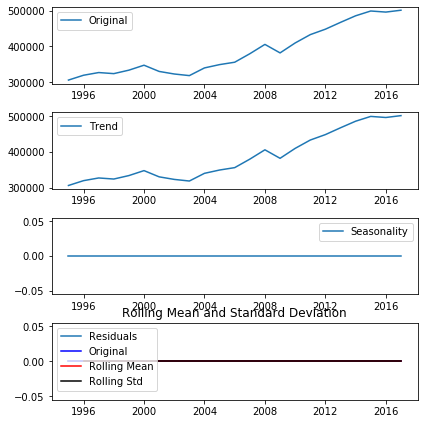

Results of Dickey-Fuller Test:
Test Statistic                  -3.353548
p-value                          0.012648
#Lags Used                       9.000000
Numbers of observations used    13.000000
Critical Value (1%)             -4.068854
Critical Value (5%)             -3.127149
Critical Value (10%)            -2.701730
dtype: float64


In [72]:
decomposition = seasonal_decompose(trial_sqrtScale)
fig = plt.figure(figsize=(6,6))
trend= decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(trial_sqrtScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)



test_stationarity(decomposedLogData, 'Receipt')

As mentioned above, the seasonality is represented as a flat line here since the yearly data is not recorded on monht-level intervals and then aggregated, but instead each yearly value is the total at the same period each year. 

Nevertheless, we can go forward and find the p and q values of the ARIMA model in the following step.

6. ACF and PACF graphs need to be ploted in order to find the values of p and q for the ARIMA (p,d,q) model

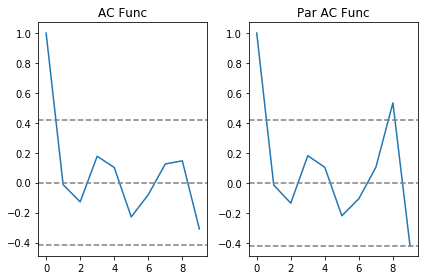

In [73]:
#ACF and PACF graphs
lag_acf = acf(datasetLogDiffShifting, nlags=9,fft=False)
lag_pacf = pacf(datasetLogDiffShifting, nlags=9, method = 'ols')

#plot ACF (Autocorrelation Graph)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle = '--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.title("AC Func")

#plot PACF (Partial Autocorrelation Graph)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle = '--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle = '--', color='gray')
plt.title("Par AC Func")
plt.tight_layout()

In order to obtain the p and q values we need to look at the graphs above, and see where they drop to zero for the first time. These can now be substituted in the ARIMA model below.

Plotting AR model


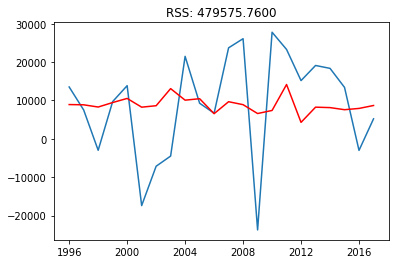

In [74]:
model= ARIMA(trial_sqrtScale, order=(2,1,1),freq='AS')
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum(results_ARIMA.fittedvalues-datasetLogDiffShifting['Receipt'])**2)
print('Plotting AR model')

7. Fitting the values in a combined model to use for prediction

In [75]:
# converting the fitted values into a series format, while applying the cumulative sum function
predictions_ARIMA_diff_cumsum = pd.Series(results_ARIMA.fittedvalues, copy=True).cumsum()

In [76]:
# predictions for the fitted values

predictions_ARIMA_log = pd.Series(trial_sqrtScale['Receipt'].iloc[0], index=trial_sqrtScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)

8. Using the results to predict the future values for the next 5 years

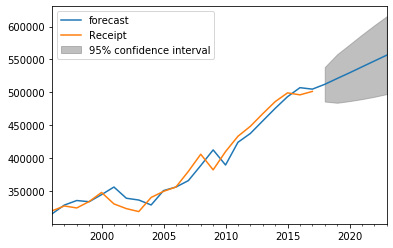

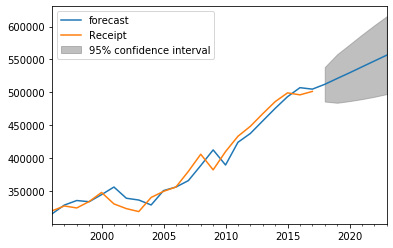

In [77]:
results_ARIMA.plot_predict(1,28)

It is important to note that the predictions are not extremely accurate due to the discussed limitations in the dataset; although they are a good indication of the direction of the future fluctuations.